Sample Initial Analysis
===

Attempting to identify misclassifications.

In [1]:
import mwapi
import mwxml
import mwxml.utilities
import mwcli
import mwreverts
import oresapi
import mwparserfromhell

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [3]:
import os
from tqdm import tqdm
import bz2
import gzip
import json
import re
import hashlib
from datetime import datetime
import nltk
import scipy.stats
import para
from itertools import groupby
from collections import Counter

In [64]:
from IPython.display import HTML, display

In [4]:
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = git_root_dir[0]
git_root_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback'

In [5]:
raw_data_dir = "/export/scratch2/wiki_data"
derived_data_dir = os.path.join(git_root_dir, "data", "derived")
raw_data_dir, derived_data_dir

('/export/scratch2/wiki_data',
 '/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived')

In [6]:
working_dir = os.path.join(derived_data_dir, 'revision_sample')
os.makedirs(working_dir, exist_ok=True)
working_dir

'/export/scratch2/levon003/repos/wiki-ores-feedback/data/derived/revision_sample'

In [7]:
start_date = datetime.fromisoformat('2018-01-01')
start_timestamp = int(start_date.timestamp())
end_date = datetime.fromisoformat('2020-01-01')
end_timestamp = int(end_date.timestamp())
start_timestamp, end_timestamp

(1514786400, 1577858400)

In [8]:
sample_start_timestamp = start_timestamp
sample_end_date = datetime.fromisoformat('2019-01-01')
sample_end_timestamp = int(end_date.timestamp())

In [41]:
cmap = matplotlib.cm.Set2

### Load the sample

In [9]:
# read in the sample dataframe
revision_sample_dir = os.path.join(derived_data_dir, 'revision_sample')
sample1_filepath = os.path.join(revision_sample_dir, 'sample1_1M.pkl')
rev_df = pd.read_pickle(sample1_filepath)
len(rev_df)

1000000

In [10]:
rev_df.head()

,page_id,rev_id,rev_timestamp,is_revert_target,is_reverted,is_reverting,is_sample_eligible,prev_rev_id,next_rev_id,prev_rev_timestamp,next_rev_timestamp,reverted_rev_ids,reverting_rev_id,reverting_rev_timestamp
29999548,9516095,846835190,1529576038,0,0,0,True,846835009,850539656,1529575914,1531769146,[],-1,-1
12474631,876872,923997118,1572595746,0,0,0,True,923211396,924618182,1572162918,1572930319,[],-1,-1
62536703,53465104,867368228,1541425108,0,0,0,True,867366487,867663184,1541423455,1541590304,[],-1,-1
73902987,60096152,888337768,1552936050,0,0,0,True,888337457,888338754,1552935890,1552936561,[],-1,-1
43843955,28063274,917010365,1569117229,0,0,0,True,915190631,-1,1568247118,-1,[],-1,-1


### Load ORES scores

In [11]:
# read in the ORES scores
revision_sample_dir = os.path.join(derived_data_dir, 'revision_sample')
sample1_filepath = os.path.join(revision_sample_dir, 'sample1_ores_scores.csv')
ores_df = pd.read_csv(sample1_filepath, header=None, names=['rev_id', 'damaging_prob', 'damaging_pred', 'goodfaith_prob', 'goodfaith_pred'])
len(ores_df)

903870

In [14]:
Counter(ores_df.damaging_pred)

Counter({False: 807097, True: 92017, nan: 4756})

In [16]:
# drop all rows without predictions
ores_df = ores_df.dropna(axis='index')

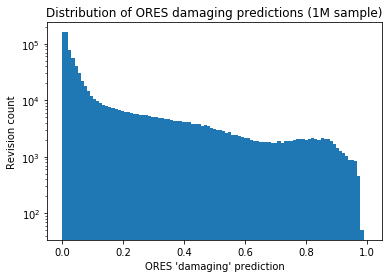

In [26]:
plt.hist(ores_df.damaging_prob, bins=np.linspace(0, 1, num=100), log=True)
plt.title("Distribution of ORES damaging predictions (1M sample)")
plt.xlabel("ORES 'damaging' prediction")
plt.ylabel("Revision count")
plt.show()

In [28]:
rev_df = pd.merge(rev_df, ores_df, on='rev_id', how='inner')
len(rev_df)

899114

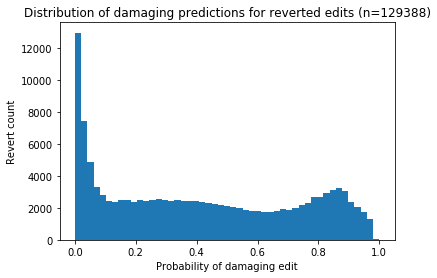

In [30]:
x = rev_df[rev_df.is_reverted==1].damaging_prob
plt.hist(x, bins=np.linspace(0, 1, num=50), log=False)
plt.title(f"Distribution of damaging predictions for reverted edits (n={len(x)})")
plt.xlabel("Probability of damaging edit")
plt.ylabel("Revert count")
plt.show()

In [32]:
reverted_subset = rev_df[rev_df.is_reverted==1].copy()
reverted_subset['time_to_revert'] = reverted_subset.reverting_rev_timestamp - reverted_subset.rev_timestamp

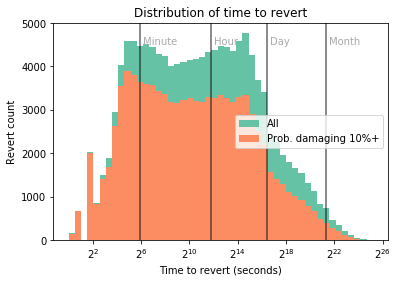

In [46]:
num_bins=50
base = 2
x = np.clip(reverted_subset.time_to_revert, 1, None)
logbins = np.logspace(np.log2(min(x)), np.log2(max(x)), num=num_bins, base=base, endpoint=True)
plt.hist(x, bins=logbins, log=False, label='All', color=cmap(0))
plt.hist(x[reverted_subset.damaging_prob >= 0.1], bins=logbins, log=False, label='Prob. damaging 10%+', alpha=1, color=cmap(0.2))
plt.xscale('log', nonposx='clip', basex=base)

ax = plt.gca()
# add semantically interpretable time moments
ax.axvline(1 * 60, color='black', alpha=0.6)
ax.axvline(1 * 60 * 60, color='black', alpha=0.6)
ax.axvline(1 * 60 * 60 * 24, color='black', alpha=0.6)
ax.axvline(1 * 60 * 60 * 24 * 30, color='black', alpha=0.6)
text_y = ax.transData.inverted().transform((0, ax.transAxes.transform((0, 0.90))[1]))[1]  # https://matplotlib.org/users/transforms_tutorial.html
ax.text(1 * 60 * 1.2, text_y, 'Minute', color='darkgray')
ax.text(1 * 60 * 60 * 1.2, text_y, 'Hour', color='darkgray')
ax.text(1 * 60 * 60 * 24 * 1.2, text_y, 'Day', color='darkgray')
ax.text(1 * 60 * 60 * 24 * 30 * 1.2, text_y, 'Month', color='darkgray')

plt.legend(loc='center right')
plt.title("Distribution of time to revert")
plt.xlabel("Time to revert (seconds)")
plt.ylabel("Revert count")
plt.show()

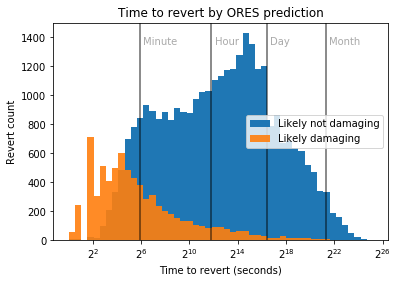

In [48]:
num_bins=50
base = 2
x = np.clip(reverted_subset.time_to_revert, 1, None)
logbins = np.logspace(np.log2(min(x)), np.log2(max(x)), num=num_bins, base=base, endpoint=True)
plt.hist(x[reverted_subset.damaging_prob <= 0.1], bins=logbins, log=False, label='Likely not damaging')
plt.hist(x[reverted_subset.damaging_prob >= 0.9], bins=logbins, log=False, label='Likely damaging', alpha=0.9)
plt.xscale('log', nonposx='clip', basex=base)

ax = plt.gca()
# add semantically interpretable time moments
ax.axvline(1 * 60, color='black', alpha=0.6)
ax.axvline(1 * 60 * 60, color='black', alpha=0.6)
ax.axvline(1 * 60 * 60 * 24, color='black', alpha=0.6)
ax.axvline(1 * 60 * 60 * 24 * 30, color='black', alpha=0.6)
text_y = ax.transData.inverted().transform((0, ax.transAxes.transform((0, 0.90))[1]))[1]  # https://matplotlib.org/users/transforms_tutorial.html
ax.text(1 * 60 * 1.2, text_y, 'Minute', color='darkgray')
ax.text(1 * 60 * 60 * 1.2, text_y, 'Hour', color='darkgray')
ax.text(1 * 60 * 60 * 24 * 1.2, text_y, 'Day', color='darkgray')
ax.text(1 * 60 * 60 * 24 * 30 * 1.2, text_y, 'Month', color='darkgray')

plt.legend(loc='center right')
plt.title("Time to revert by ORES prediction")
plt.xlabel("Time to revert (seconds)")
plt.ylabel("Revert count")
plt.show()

In [49]:
f"The median likely-damaging revert is reverted in {np.quantile(x[reverted_subset.damaging_prob >= 0.9], 0.5):.1f} seconds, while the median likely-non-damaging revert is reverted in {np.quantile(x[reverted_subset.damaging_prob <= 0.1], 0.5)/60:.1f} minutes."

'The median likely-damaging revert is reverted in 30.0 seconds, while the median likely-non-damaging revert is reverted in 113.2 minutes.'

In [51]:
# the expected negative correlation exists
scipy.stats.pearsonr(reverted_subset.damaging_prob, np.log(np.clip(reverted_subset.time_to_revert, 1, None)))

(-0.37750188713616134, 0.0)

### Text retrieval functions

In [65]:
def get_comparison_html(prev_rev_id, rev_id):
    session = mwapi.Session("https://en.wikipedia.org/w/api.php", user_agent="levon003@umn.edu - revision text retrieval")
    params = {
        'action': 'compare',
        'format': 'json',
        'formatversion': '2',
        'fromrev': prev_rev_id,
        'torev': rev_id,
    }
    result = session.get(params)
    return result['compare']['body']

def display_comparison_html(prev_rev_id, rev_id):
    display(HTML(get_comparison_html(prev_rev_id, rev_id)))

### False Positives analysis

Looking at cases where ORES prediction is high, but (a) revision was only reverted after a long period of time or (b) a long period of time separates this revision from the next.

In [59]:
one_day = 60 * 60 * 24  # in seconds
fp_time_threshold = one_day
fp_predicted_prob_threshold = 0.9

In [60]:
np.sum(reverted_subset.time_to_revert >= fp_time_threshold) / len(reverted_subset)

0.13209107490648284

In [61]:
np.sum(reverted_subset.damaging_prob >= fp_predicted_prob_threshold) / len(reverted_subset)

0.055669768448387794

In [63]:
reverted_potential_false_positives = reverted_subset[(reverted_subset.time_to_revert >= fp_time_threshold)&(reverted_subset.damaging_prob >= fp_predicted_prob_threshold)]
len(reverted_potential_false_positives), len(reverted_potential_false_positives) / len(reverted_subset)

(135, 0.0010433734194824867)

Only 135 (0.1% of the reverts!) reverted revisions were reverted after more than a day and have a predicted ORES damaging probability of $\ge 0.9$.

In [67]:
import ipywidgets as widgets

In [96]:
from IPython.display import display
damaging_button = widgets.Button(description="Damaging (True Positive)", layout={
    'width': '100%',
    'overflow': 'visible',
})
unknown_button = widgets.Button(description="Unknown", layout={
    'width': '100%',
    'overflow': 'visible',
})
not_damaging_button = widgets.Button(description="Not Damaging (False Positive)", layout={
    'width': '100%',
    'overflow': 'visible',
})
back_button = widgets.Button(description="Back", layout={
    'width': '100%',
    'overflow': 'visible',
})
output = widgets.Output(layout={
    'width': '100%',
    'overflow': 'visible',
})

display(damaging_button, unknown_button, not_damaging_button, back_button, output)

global annotation_index
annotation_index = -1
def on_button_clicked(b):
    global annotation_index
    backward = False
    record_annotation = True
    annotation = ""
    if b.description.startswith('Back'):
        backward = True  # we are going back
        record_annotation = False
    elif b.description.startswith('Not'):
        annotation = "not_damaging"
    elif b.description.startswith('Unknown'):
        annotation = 'unknown'
    else:
        annotation = "damaging"
    
    if record_annotation and annotation_index >= 0:
        with open(os.path.join(working_dir, 'fp_revert_annotation.csv'), 'a') as outfile:
            tup = reverted_potential_false_positives.iloc[annotation_index]
            rev_id = tup.rev_id
            curr_time = int(datetime.now().timestamp())
            outfile.write(f"{rev_id},{annotation},{curr_time}\n")
    
    with output:
        output.clear_output()
        if backward:
            annotation_index -= 1
        else:
            annotation_index += 1
        tup = reverted_potential_false_positives.iloc[annotation_index]
        display_comparison_html(tup.prev_rev_id, tup.rev_id)

damaging_button.on_click(on_button_clicked)
unknown_button.on_click(on_button_clicked)
not_damaging_button.on_click(on_button_clicked)
back_button.on_click(on_button_clicked)

Button(description='Damaging (True Positive)', layout=Layout(overflow='visible', width='100%'), style=ButtonSt…

Button(description='Unknown', layout=Layout(overflow='visible', width='100%'), style=ButtonStyle())

Button(description='Not Damaging (False Positive)', layout=Layout(overflow='visible', width='100%'), style=But…

Button(description='Back', layout=Layout(overflow='visible', width='100%'), style=ButtonStyle())

Output(layout=Layout(overflow='visible', width='100%'))

In [92]:
annotations = pd.read_csv(os.path.join(working_dir, 'fp_revert_annotation.csv'), header=None, names=['rev_id', 'annotation', 'annotation_time'])
len(annotations)

139

In [94]:
annotations = annotations.drop_duplicates(subset='rev_id', keep='last')
len(annotations)

135

In [95]:
Counter(annotations.annotation).most_common()

[('damaging', 119), ('unknown', 13), ('not_damaging', 3)]

### False Negatives analysis

Low ORES score but a rapid revision.

In [100]:
fn_time_threshold = 60  # 60 seconds
fn_predicted_prob_threshold = 0.1

In [101]:
np.sum(reverted_subset.time_to_revert <= fn_time_threshold) / len(reverted_subset)

0.19808637586174915

In [102]:
np.sum(reverted_subset.damaging_prob <= fn_predicted_prob_threshold) / len(reverted_subset)

0.23963582403314063

In [103]:
reverted_potential_false_negatives = reverted_subset[(reverted_subset.time_to_revert <= fn_time_threshold)&(reverted_subset.damaging_prob <= fn_predicted_prob_threshold)]
len(reverted_potential_false_negatives), len(reverted_potential_false_negatives) / len(reverted_subset)

(3092, 0.02389711565214703)

In [104]:
from IPython.display import display
damaging_button = widgets.Button(description="Damaging (False Negative)", layout={
    'width': '100%',
    'overflow': 'visible',
})
unknown_button = widgets.Button(description="Unknown", layout={
    'width': '100%',
    'overflow': 'visible',
})
not_damaging_button = widgets.Button(description="Not Damaging (True Negative)", layout={
    'width': '100%',
    'overflow': 'visible',
})
back_button = widgets.Button(description="Back", layout={
    'width': '100%',
    'overflow': 'visible',
})
output = widgets.Output(layout={
    'width': '100%',
    'overflow': 'visible',
})

display(not_damaging_button, unknown_button, damaging_button, back_button, output)

global annotation_index
annotation_index = -1
def on_button_clicked(b):
    global annotation_index
    backward = False
    record_annotation = True
    annotation = ""
    if b.description.startswith('Back'):
        backward = True  # we are going back
        record_annotation = False
    elif b.description.startswith('Not'):
        annotation = "not_damaging"
    elif b.description.startswith('Unknown'):
        annotation = 'unknown'
    else:
        annotation = "damaging"
    
    if record_annotation and annotation_index >= 0:
        with open(os.path.join(working_dir, 'fn_revert_annotation.csv'), 'a') as outfile:
            tup = reverted_potential_false_negatives.iloc[annotation_index]
            rev_id = tup.rev_id
            curr_time = int(datetime.now().timestamp())
            outfile.write(f"{rev_id},{annotation},{curr_time}\n")
    
    with output:
        output.clear_output()
        if backward:
            annotation_index -= 1
        else:
            annotation_index += 1
        tup = reverted_potential_false_negatives.iloc[annotation_index]
        display_comparison_html(tup.prev_rev_id, tup.rev_id)

damaging_button.on_click(on_button_clicked)
unknown_button.on_click(on_button_clicked)
not_damaging_button.on_click(on_button_clicked)
back_button.on_click(on_button_clicked)

Button(description='Not Damaging (True Negative)', layout=Layout(overflow='visible', width='100%'), style=Butt…

Button(description='Unknown', layout=Layout(overflow='visible', width='100%'), style=ButtonStyle())

Button(description='Damaging (False Negative)', layout=Layout(overflow='visible', width='100%'), style=ButtonS…

Button(description='Back', layout=Layout(overflow='visible', width='100%'), style=ButtonStyle())

Output(layout=Layout(overflow='visible', width='100%'))

In [108]:
annotations = pd.read_csv(os.path.join(working_dir, 'fn_revert_annotation.csv'), header=None, names=['rev_id', 'annotation', 'annotation_time'])
len(annotations)

20

In [109]:
annotations = annotations.drop_duplicates(subset='rev_id', keep='last')
len(annotations)

20

In [110]:
Counter(annotations.annotation).most_common()

[('unknown', 10), ('not_damaging', 8), ('damaging', 2)]

In [11]:
rev_id_list = rev_df.rev_id
len(rev_id_list)

1000000

In [15]:
session = mwapi.Session("https://en.wikipedia.org/w/api.php", user_agent="levon003@umn.edu - revision text retrieval")

In [16]:
params = {
    'action': 'query',
    'format': 'json',
    'pageids': str(43825897),
    'prop': 'info',
    'inprop': 'url'
}
session.get(params)

{'batchcomplete': '',
 'query': {'pages': {'43825897': {'pageid': 43825897,
    'ns': 0,
    'title': 'Bethel Church, Mansfield Woodhouse',
    'contentmodel': 'wikitext',
    'pagelanguage': 'en',
    'pagelanguagehtmlcode': 'en',
    'pagelanguagedir': 'ltr',
    'touched': '2020-02-09T10:07:54Z',
    'lastrevid': 870460930,
    'length': 20559,
    'fullurl': 'https://en.wikipedia.org/wiki/Bethel_Church,_Mansfield_Woodhouse',
    'editurl': 'https://en.wikipedia.org/w/index.php?title=Bethel_Church,_Mansfield_Woodhouse&action=edit',
    'canonicalurl': 'https://en.wikipedia.org/wiki/Bethel_Church,_Mansfield_Woodhouse'}}}}

In [57]:
params = {
    'action': 'query',
    'format': 'json',
    'formatversion': '2',
    'revids': "|".join([str(rev_id) for rev_id in rev_id_list[:50]]),
    'prop': 'revisions',
    'rvprop': 'timestamp|user|comment|content',
    'rvslots': 'main',
}
result = session.get(params)

In [58]:
result.keys()

dict_keys(['batchcomplete', 'query'])

In [59]:
result['batchcomplete']

True

In [60]:
result['query']['pages'][0].keys()

dict_keys(['pageid', 'ns', 'title', 'revisions'])

In [61]:
result['query']['pages'][0]['revisions'][0].keys()

dict_keys(['user', 'anon', 'timestamp', 'slots', 'comment'])

In [62]:
result['query']['pages'][0]['revisions'][0]['slots']['main'].keys()

dict_keys(['contentmodel', 'contentformat', 'content'])

In [63]:
result['query']['pages'][0]['revisions'][0]['slots']['main']['content']

'{{distinguish|text=the [[Qing dynasty]], the last dynasty of Imperial China}}\n{{redirect|Qin Empire||Qin Empire (disambiguation)}}\n{{pp-pc1}}\n{{Use dmy dates|date=November 2013}}\n{{Use British English|date=August 2017}}\n{{Infobox former country\n|native_name = {{big|{{nobold|{{lang|zh|秦}}}}}}\n|conventional_long_name = Qin\n|common_name = Qin dynasty\n|continent = Asia\n|region = East Asia\n|era = [[Imperial era of Chinese history|Imperial]]\n|status = Empire\n|status_text =\n|government_type = [[Absolute monarchy]]\n|p1 = Zhou dynasty\n|p2 = Qin (state)\n|s1 = Eighteen Kingdoms\n|s2 = Han dynasty\n|s3 = Nanyue\n|event_start = {{nowrap|[[Qin\'s wars of unification|Unification of China]]}}\n|year_start = 221 BC\n|event1 = {{nowrap|Death of [[Qin Shi Huang]]}}\n|date_event1 = 210 BC\n|event2 = |date_event2 = |event3 = |date_event3 = |event4 = |date_event4 = |event5 = |date_event5 = \n|event_end = {{nowrap|Surrender to [[Liu Bang]]}}\n|year_end = 206 BC\n|image_map2 = Qin Dynasty.pn

In [42]:
tup = rev_df.iloc[0]
tup

page_id                       9516095
rev_id                      846835190
rev_timestamp              1529576038
is_revert_target                    0
is_reverted                         0
is_reverting                        0
is_sample_eligible               True
prev_rev_id                 846835009
next_rev_id                 850539656
prev_rev_timestamp         1529575914
next_rev_timestamp         1531769146
reverted_rev_ids                   []
reverting_rev_id                   -1
reverting_rev_timestamp            -1
Name: 29999548, dtype: object

### Comparing

In [54]:
params = {
    'action': 'compare',
    'format': 'json',
    'formatversion': '2',
    'fromrev': tup.prev_rev_id,
    'torev': tup.rev_id,
}
session.get(params)

{'compare': {'fromid': 9516095,
  'fromrevid': 846835009,
  'fromns': 0,
  'fromtitle': 'Weihai Dashuibo Airport',
  'toid': 9516095,
  'torevid': 846835190,
  'tons': 0,
  'totitle': 'Weihai Dashuibo Airport',
  'body': '<tr>\n  <td colspan="2" class="diff-lineno">Line 47:</td>\n  <td colspan="2" class="diff-lineno">Line 47:</td>\n</tr>\n<tr>\n  <td class="diff-marker">&#160;</td>\n  <td class="diff-context"><div>| [[Chengdu Airlines]] | [[Changchun Longjia International Airport|Changchun]]</div></td>\n  <td class="diff-marker">&#160;</td>\n  <td class="diff-context"><div>| [[Chengdu Airlines]] | [[Changchun Longjia International Airport|Changchun]]</div></td>\n</tr>\n<tr>\n  <td class="diff-marker">&#160;</td>\n  <td class="diff-context"><div>| [[China Airlines]] | [[Taiwan Taoyuan International Airport|Taipei–Taoyuan]]</div></td>\n  <td class="diff-marker">&#160;</td>\n  <td class="diff-context"><div>| [[China Airlines]] | [[Taiwan Taoyuan International Airport|Taipei–Taoyuan]]</div

In [55]:
display(HTML(session.get(params)['compare']['body']  ))